In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
import pickle
import json

2025-05-27 21:14:21.069627: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 21:14:21.097945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748355261.130260   35853 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748355261.140996   35853 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748355261.176566   35853 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Load CIFAR-10
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Create train/validation split (40k train, 10k validation)
split_idx = 40000

x_train = x_train_full[:split_idx]
y_train = y_train_full[:split_idx].flatten()
x_val = x_train_full[split_idx:]
y_val = y_train_full[split_idx:].flatten()
x_test = x_test
y_test = y_test.flatten()

In [3]:
# CONSTANTS
epochs = 20
save_dir = "../output"
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [4]:
def create_model_with_n_conv_layers(num_conv_layers):
    model = keras.Sequential()
    
    # Define base filter progression
    base_filters = [32, 64, 128, 256]
    
    # Add convolutional layers
    for i in range(num_conv_layers):
        filters = base_filters[i] if i < len(base_filters) else base_filters[-1]
        
        if i == 0:
            model.add(keras.layers.Conv2D(filters, 3, activation='relu', 
                                        input_shape=(32, 32, 3),
                                        padding='same'))
        else:
            model.add(keras.layers.Conv2D(filters, 3, activation='relu',
                                        padding='same'))
        
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(2, 2))
        model.add(keras.layers.Dropout(0.25))
    
    # Add dense layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [5]:
def train_model(model, model_name, epochs=20):    
    # Compile model
    model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    
    model.summary()

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        callbacks=[early_stopping])
    
    # Save model and weights
    model.save_weights(f'{save_dir}/models/{model_name}.weights.h5')
    model.save(f'{save_dir}/models/{model_name}.model.h5')
    
    # Save training history
    with open(f'{save_dir}/results/{model_name}_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    
    return history

In [6]:
def evaluate_model(model, model_name):
    # Predict on test set
    y_pred = model.predict(x_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate metrics
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    f1_macro = f1_score(y_test, y_pred_classes, average='macro')
    
    # Detailed results
    results = {
        'model_name': model_name,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'macro_f1_score': f1_macro,
        'classification_report': classification_report(y_test, y_pred_classes, 
                                                        target_names=class_names, 
                                                        output_dict=True)
    }
    
    # Save results
    with open(f'{save_dir}/results/{model_name}_evaluation.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    return results

In [7]:
def plot_training_history(layers, history, experiment_name):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Plot training and validation loss
    color = colors[layers % len(colors)]
    ax1.plot(history.history['loss'], color=color, linestyle='-', 
            label=f'{layers} layers (train)')
    ax1.plot(history.history['val_loss'], color=color, linestyle='--', 
            label=f'{layers} layers (val)')
    
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training and validation accuracy
    color = colors[layers % len(colors)]
    ax2.plot(history.history['accuracy'], color=color, linestyle='-', 
            label=f'{layers} layers (train)')
    ax2.plot(history.history['val_accuracy'], color=color, linestyle='--', 
            label=f'{layers} layers (val)')
        
    
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'{experiment_name} - Training History Comparison', fontsize=16)
    plt.tight_layout()

    plt.show()

## Variasi 1 (2 layer)

In [8]:
# Create model
layers = 2
model = create_model_with_n_conv_layers(layers)
model_name = f"conv_{layers}_layers"

# Train model
history = train_model(model, model_name, epochs)
result = evaluate_model(model, model_name)

/home/sandwicheese/Projects/Tubes2_ML/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748355268.470379   35853 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,634 (1.08 MB)

 Trainable params: 282,442 (1.08 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20


I0000 00:00:1748355271.624576   35974 service.cc:152] XLA service 0x7efd4400e9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748355271.624622   35974 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-05-27 21:14:31.657099: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748355271.851880   35974 cuda_dnn.cc:529] Loaded cuDNN version 90300


  29/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1172 - loss: 3.3669

I0000 00:00:1748355274.779542   35974 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1521 - loss: 2.2668 - val_accuracy: 0.2596 - val_loss: 1.8865
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2282 - loss: 1.9773 - val_accuracy: 0.3600 - val_loss: 1.7161
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2834 - loss: 1.8720 - val_accuracy: 0.3976 - val_loss: 1.6908
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3250 - loss: 1.7682 - val_accuracy: 0.4007 - val_loss: 1.7442
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3640 - loss: 1.6730 - val_accuracy: 0.5426 - val_loss: 1.3107
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4260 - loss: 1.5383 - val_accuracy: 0.4575 - val_loss: 1.7101
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4697 - loss: 1.4486 - val_accuracy: 0.5697 - val_loss: 1.2178
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5027 - loss: 1.3714 - val_accura

Test Accuracy: 0.6984
Macro F1-Score: 0.7040
Test Loss: 0.8817


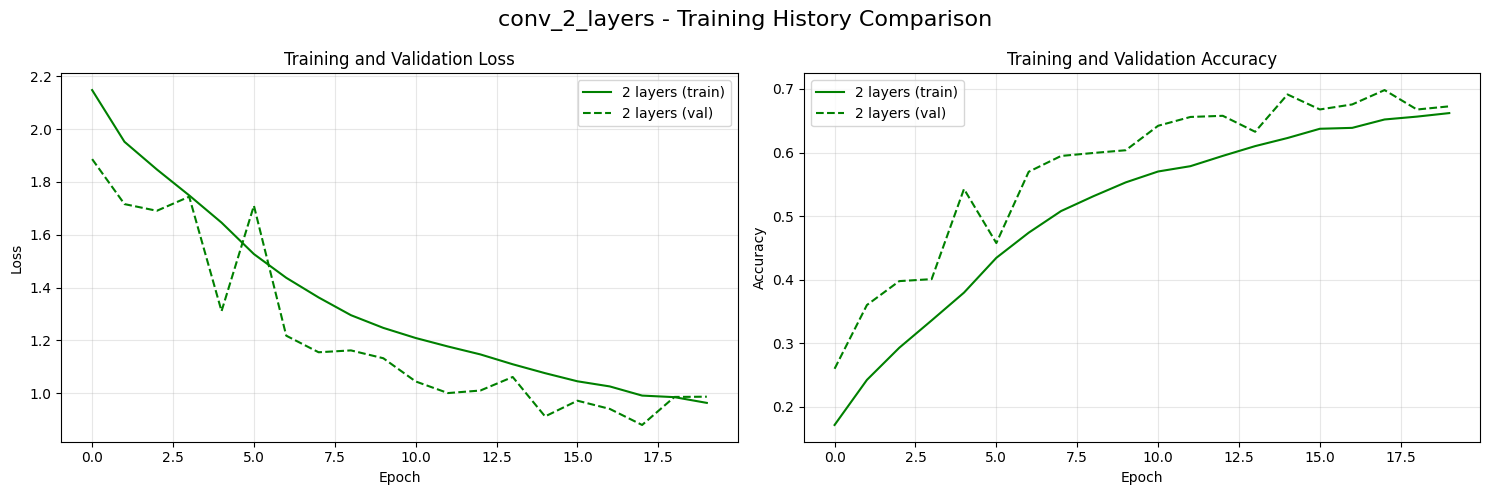

In [9]:
plot_training_history(layers, history, model_name)

## Variasi 2 (3 layer)

In [10]:
# Create model
layers = 3
model = create_model_with_n_conv_layers(layers)
model_name = f"conv_{layers}_layers"

# Train model
history = train_model(model, model_name, epochs)
result = evaluate_model(model, model_name)

/home/sandwicheese/Projects/Tubes2_ML/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,930 (882.54 KB)

 Trainable params: 225,482 (880.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.2286 - loss: 2.1337 - val_accuracy: 0.3985 - val_loss: 1.6005
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3597 - loss: 1.6980 - val_accuracy: 0.3973 - val_loss: 2.0070
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4295 - loss: 1.5346 - val_accuracy: 0.5038 - val_loss: 1.3599
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4670 - loss: 1.4419 - val_accuracy: 0.5806 - val_loss: 1.1921
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4974 - loss: 1.3706 - val_accuracy: 0.6025 - val_loss: 1.1546
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5340 - loss: 1.2883 - val_accuracy: 0.6366 - val_loss: 1.0555
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5698 - loss: 1.2049 - val_accuracy: 0.6797 - val_loss: 0.9350
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5926 - loss: 1.1488 -

Test Accuracy: 0.7520
Macro F1-Score: 0.7513
Test Loss: 0.7252


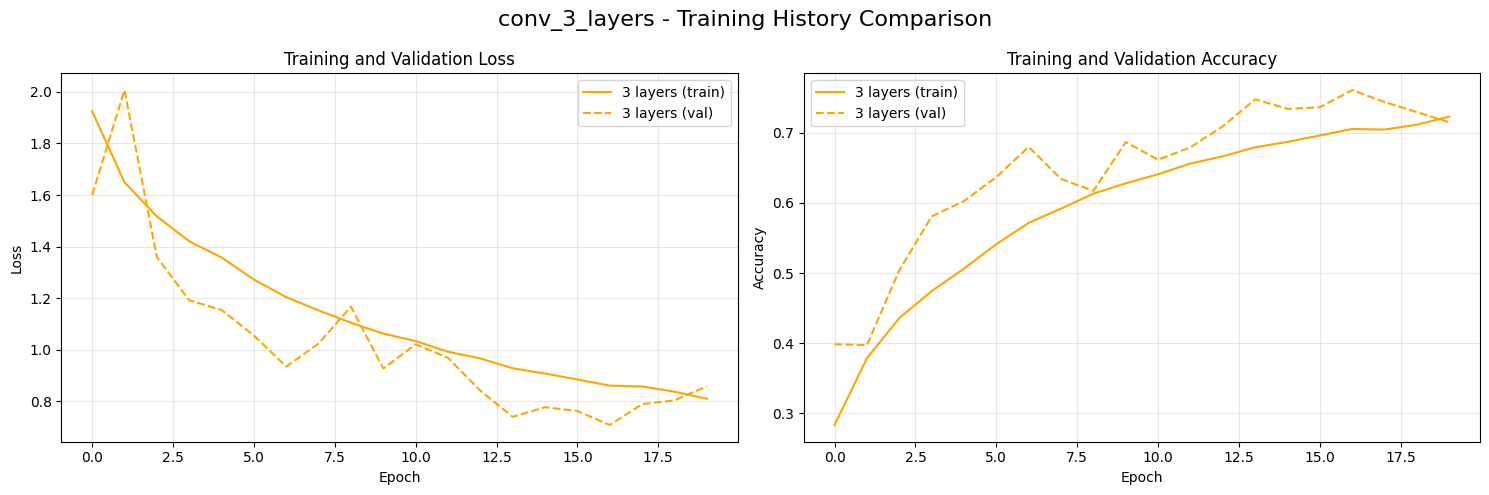

In [11]:
plot_training_history(layers, history, model_name)

## Variasi 3 (4 layer)

In [12]:
# Create model
layers = 4
model = create_model_with_n_conv_layers(layers)
model_name = f"conv_{layers}_layers"

# Train model
history = train_model(model, model_name, epochs)
result = evaluate_model(model, model_name)

/home/sandwicheese/Projects/Tubes2_ML/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,586 (1.74 MB)

 Trainable params: 455,626 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.2212 - loss: 2.1633 - val_accuracy: 0.2378 - val_loss: 2.5063
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3701 - loss: 1.6661 - val_accuracy: 0.5319 - val_loss: 1.3154
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4595 - loss: 1.4744 - val_accuracy: 0.5227 - val_loss: 1.2829
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5210 - loss: 1.3301 - val_accuracy: 0.5867 - val_loss: 1.1744
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5526 - loss: 1.2445 - val_accuracy: 0.5505 - val_loss: 1.3805
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5920 - loss: 1.1545 - val_accuracy: 0.6570 - val_loss: 0.9607
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6152 - loss: 1.0955 - val_accuracy: 0.6007 - val_loss: 1.2421
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6323 - loss: 1.0532 -

Test Accuracy: 0.7623
Macro F1-Score: 0.7655
Test Loss: 0.6998


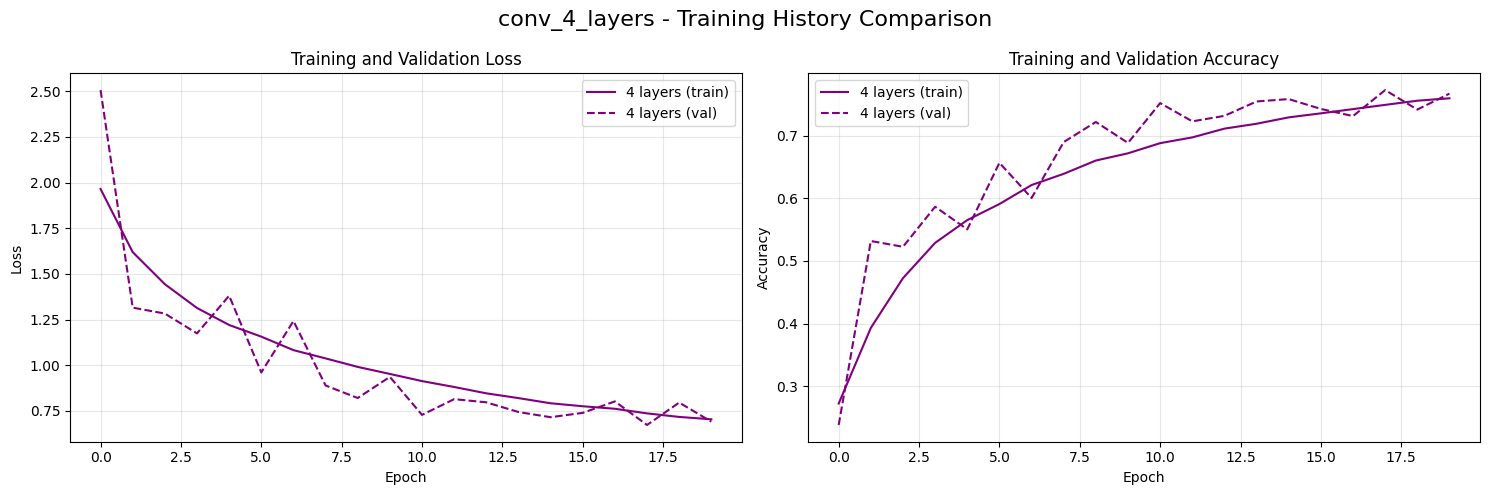

: 

In [ ]:
plot_training_history(layers, history, model_name)